In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pyclustering.cluster import cure
from collections import namedtuple
import torchvision.transforms.functional as TF
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

### Constants

In [27]:
DATA_DIR = '../segmentation/data/segmentation_data/'
DATA_DIR = os.path.realpath(DATA_DIR)

FEATURES = ['roads', 'railroads', 'wetlands']
POSITIVE = 'railroads'
NEGATIVE = [feature for feature in FEATURES if feature != POSITIVE]

N_SAMPLES = 400 # for each class
N_AUG_POS = 4
N_AUG_NEG = 0

BATCH_SIZE = 10

ROTATION_RANGE = 180
WINDOW_SIZE = 320

NUM_WORKERS = 2

LOAD_MODEL = False
LOAD_MODEL_PATH = 'checkpoints/epoch_5.pth'
CHECKPOINTS_DIR = 'checkpoints/'

MASK_THRESHOLD = 0.5

### Sample points (pixels) to work with

In [3]:
maps, masks = [], []
# pos_file = [] # using mask to determine the positive pixels/coors
neg_files = []

for map_dir in os.listdir(DATA_DIR):
    _, _, files = list(os.walk(os.path.join(DATA_DIR, map_dir)))[0]
    n = []
    for f in files:
        filepath = os.path.join(DATA_DIR, map_dir, f)    
        
        if f.startswith('map_'):
            maps.append(filepath)
            
        elif f.startswith('mask_'):
            masks.append(filepath)
            
        else:
            for neg in NEGATIVE:
                if neg in f.lower() and POSITIVE not in f.lower() and f.endswith('.txt'):
                    n.append(filepath)
    neg_files.append(n)

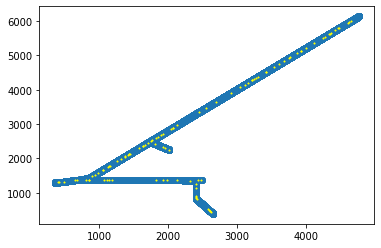

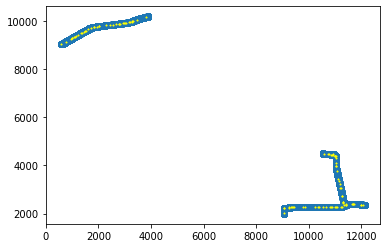

In [4]:
def write_sample_points(samples, filename):
    with open(filename, 'w') as f:
        output = [("%d,%d" % (s[0],s[1])) for s in samples]
        output = '\n'.join(output)
        f.write(output)

        
def sample_points(maps, masks, neg_files, representors=False, plot_pos=False):
    ''' Sample points/pixels/coors to generate training data from '''
    
    for m, mask, negf in zip(maps, masks, neg_files):
        filepath = os.path.split(m)[0]
        
        mask = cv2.imread(mask)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        pos_pixels = np.argwhere(mask==255) # pixels corresponding to positive class
#         print(pos_pixels.shape)
#         print(pos_pixels)


        n_pos = N_SAMPLES // N_AUG_POS
        if representors:
            # great, but takes forever
            representors = cure.cure(pos_pixels, number_cluster=1, number_represent_points=n_pos, compression=0)
            representors = representors.process().get_representors()
            pos_samples = np.asarray(representors[0], dtype=int)
        else: # sample randomly
            pos_samples = np.random.choice(len(pos_pixels), n_pos, replace=False)
            pos_samples = pos_pixels[pos_samples]
        write_sample_points(pos_samples, os.path.join(filepath, 'pos.txt'))
        
        if plot_pos:
            plt.figure()
            plt.scatter(pos_pixels[:,0], pos_pixels[:,1])
            plt.scatter(pos_samples[:,0], pos_samples[:,1], marker='*', color='yellow', s=1.5)
            plt.show()
        
        for i, neg in enumerate(negf, 1):
            neg_pixels = np.loadtxt(neg, dtype=int, delimiter=',', ndmin=2)
            neg_samples = np.random.choice(len(neg_pixels), N_SAMPLES, replace=False)
            neg_samples = neg_pixels[neg_samples]
            write_sample_points(neg_samples, os.path.join(filepath, 'neg%d.txt' % i))
            
            
sample_points(maps, masks, neg_files, plot_pos=True)

In [5]:
# os.path.split(maps[0])

In [6]:
DataPoint = namedtuple('CenterPixel', 'map_id coord label')
AugmentedDataPoint = namedtuple('CenterPixel', 'map_id coord label hflip vflip angle')

def get_augmented_params():
    hflip, vflip, theta = False, False, 0
    if np.random.random() < 0.5:
        hflip = True
    if np.random.random() < 0.5:
        vflip = True
    if ROTATION_RANGE:
        theta = int(np.random.uniform(-ROTATION_RANGE, ROTATION_RANGE))
    return {'hflip': hflip, 'vflip': vflip, 'angle': theta}


def is_valid(data_point, win_size=WINDOW_SIZE):
    rows, cols = loaded_maps[data_point.map_id].shape[:2]
    center_pixel = data_point.coord
    start_y = int(center_pixel[0] - (win_size - 1)/2)
    start_x = int(center_pixel[1] - (win_size - 1)/2)
    end_y = start_y + win_size
    end_x = start_x + win_size 
    if start_y >= 0 and start_x >= 0 and end_y < rows and end_x < cols:
        return True
    return False
    


def collate_data(maps, augment=True, shuffle=False): 
    dataset = []
    
    for m_ix, map_ in enumerate(maps):
        map_path, map_name = os.path.split(map_)
        _, _, files = list(os.walk(map_path))[0]
        
        for f in files:
            filepath = os.path.join(map_path, f)

            if not f.endswith('.txt'):
                continue
            if not f.startswith('pos') and not f.startswith('neg'):
                continue
            
            coords = np.loadtxt(filepath, dtype=int, delimiter=',', ndmin=2)
            label = 'p' if f.startswith('pos') else 'n'
            n_aug = N_AUG_POS if label == 'p' else N_AUG_NEG
            
            for coord in coords:
                point = DataPoint(m_ix, coord, label)
                
                if augment:
                    aug_point = AugmentedDataPoint(*point, hflip=False, vflip=False, angle=0)
                    dataset.append(aug_point) # Original
                    
                    for _ in range(n_aug):
                        aug_point = AugmentedDataPoint(*point, **get_augmented_params())
                        dataset.append(aug_point)
                
                else:
                    dataset.append(point)
                                
    if shuffle:
        np.random.shuffle(dataset)
    return dataset

In [7]:
def load_images(m_paths):
    images = []
    for mp in m_paths:
        im = cv2.imread(mp)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        images.append(im)
    return images

loaded_maps = load_images(maps)
loaded_masks = load_images(masks)

In [8]:
loaded_maps[0].shape

(8042, 6596, 3)

In [9]:
data = collate_data(maps)
data = [p for p in data if is_valid(p)]
len(data)

1800

In [31]:
class SegmentationTransform:
    ''' Returns cropped map image and mask (augmented) for a data point '''
    
    def __init__(self, image_tf=None, mask_tf=None):
        self.data_point = None
        self.image_tf = image_tf
        self.mask_tf = mask_tf
        
    def _compute_patch_start_coords(self, img, win_size):
        # TF.crop pads the image if out of bounds;
        # but `is_valid` made sure it is within bounds
        rows, cols = img.shape[:2]
        center_pixel = self.data_point.coord
        self.start_y = int(center_pixel[0] - (win_size - 1)/2)
        self.start_x = int(center_pixel[1] - (win_size - 1)/2)
    
    def _transform_image(self, x, win_size):
        x = TF.to_pil_image(x)
        x = TF.crop(x, self.start_y, self.start_x, win_size, win_size) # square
        x = TF.rotate(x, self.data_point.angle) if self.data_point.angle else x
        x = TF.hflip(x) if self.data_point.hflip else x
        x = TF.vflip(x) if self.data_point.vflip else x
        x = TF.to_tensor(x) # HWC->CHW; [0,255]->[0,1]
        if self.image_tf:
            x = self.image_tf(x)
        return x
        
    def _transform_mask(self, x, win_size):
        x = TF.to_pil_image(x)
        x = TF.to_grayscale(x)
        x = TF.crop(x, self.start_y, self.start_x, win_size, win_size) # square
        x = TF.rotate(x, self.data_point.angle) if self.data_point.angle else x
        x = TF.hflip(x) if self.data_point.hflip else x
        x = TF.vflip(x) if self.data_point.vflip else x
        x = TF.to_tensor(x) # HWC->CHW; [0,255]->[0,1]
        if self.mask_tf:
            x = self.mask_tf(x)
        return x
    
    def __call__(self, data_point, win_size=WINDOW_SIZE):
        self.data_point = data_point
        
        image = loaded_maps[data_point.map_id]
        mask = loaded_masks[data_point.map_id]
        
        assert image.shape[:2] == mask.shape[:2]
        self._compute_patch_start_coords(image, win_size)
        
        image = self._transform_image(image, win_size)
        mask = self._transform_mask(mask, win_size)
                
        return {'images': image, 'masks': mask}

In [32]:
from torch.utils.data import Dataset, DataLoader, random_split

class SegmentationDataset(Dataset):
    def __init__(self, data_points, transformer, scale=False, win_size=WINDOW_SIZE):
        self.dataset = data_points
        self.transformer = transformer
        self.win_size = win_size
        self.scale = scale
        
    def preprocess(self, data_point):
        data_point = self.transformer(data_point, self.win_size)
        # mask channels == n_classes?
        
#         data_point['image'] = data_point['mask'].to(torch.float64)
#         data_point['mask'] = data_point['mask'].to(torch.long)
#         if self.scale: # totensor transform has done that for us
#             data_point['image'] /= 255.
#             data_point['mask'] /= 255
        return data_point
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, ix):
        assert ix < self.__len__(), 'Index must be within bounds (<len)'
        return self.preprocess(self.dataset[ix])

## Dataset

In [33]:
data = collate_data(maps, shuffle=True, augment=True)
n_val = int(len(data) * 0.1)
n_train = len(data) - n_val
train, val = random_split(data, [n_train, n_val])

In [34]:
from torchvision import transforms
image_tf = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]) # DeepLabV3

transformer = SegmentationTransform(image_tf=image_tf)
train_dataset = SegmentationDataset(train, transformer)
val_dataset = SegmentationDataset(val, transformer)

In [35]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)

In [36]:
def plot_overlay(image, mask):
    if image.__class__.__name__ == 'Tensor':
        image = image.numpy().transpose((2,1,0))
        mask = mask.numpy().transpose((2,1,0)).squeeze()
    
    plt.figure()
    plt.imshow(image)
    plt.imshow(mask, cmap='gray', alpha=0.55)
    plt.show()
    

# for b, batch in enumerate(val_loader):
#     if b==1: break
#     for i in range(batch['images'].shape[0]):
#         plot_overlay(batch['images'][i], batch['masks'][i])



## Train

In [37]:
# from unet import UNet

In [38]:
def dice_coeff(pred, target):
    eps = 0.0001

    assert pred.shape[-2:] == target.shape[-2:]
    if pred.is_cuda:
        coeff = torch.FloatTensor(1).cuda().zero_()
    else:
        coeff = torch.FloatTensor(1).zero_()
    
    for i, (p, t) in enumerate(zip(pred, target)):
        p, t = p.view(-1), t.view(-1)
        numerator = (2 * torch.dot(p, t)).float()
        denominator = (p.sum() + t.sum()).float() + eps
        coeff += (numerator / denominator)

    return coeff / (i + 1)

In [39]:
p = (torch.randn((5,1,320,320)) > MASK_THRESHOLD).int()
t = torch.randint_like(p, low=0, high=1+1)
dice_coeff(p, t).item()

0.3806743025779724

In [40]:
(
    dice_coeff(torch.zeros((5,1,320,320)), torch.ones((5,1,320,320))),
    dice_coeff(torch.zeros((5,1,320,320)), torch.zeros((5,1,320,320))),
    dice_coeff(torch.ones((5,1,320,320)), torch.ones((5,1,320,320))),
)

(tensor([0.]), tensor([0.]), tensor([1.]))

In [41]:
from torchvision.models.segmentation import deeplabv3_resnet101
model = deeplabv3_resnet101(pretrained=True, progress=True, num_classes=21)

In [42]:
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

#### Classifier

In [43]:
model.classifier

DeepLabHead(
  (0): ASPP(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(36, 36), dilation=(36, 36), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [44]:
model.aux_classifier

FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
)

In [45]:
model.classifier[4], model.aux_classifier[4]

(Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1)))

In [46]:
n_classes = 1
model.classifier[4] = nn.Conv2d(256, n_classes, (1,1))
model.aux_classifier[4] = nn.Conv2d(256, n_classes, (1,1))

In [47]:
model.classifier[4], model.aux_classifier[4]

(Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1)))

In [48]:
epochs = 5
lr = 0.001
writer = SummaryWriter()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

# model = UNet(n_channels=3, n_classes=1, bilinear=True) # Segmentation Net

optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
criterion = nn.BCEWithLogitsLoss()

if LOAD_MODEL:
    model.load_state_dict(torch.load(LOAD_MODEL_PATH, map_location=device))
    
model.to(device=device)
total_iterations = 0

Device:  cpu


#### Begin training

In [50]:
try:
    for epoch in range(epochs):
        model.train() # just lets it know that now in training 'mode' (eg. manage BN/dropout behaviours)
        
        epoch_loss = 0
        
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as progress_bar:
            
            for step, batch in enumerate(train_loader):
                images, masks = batch['images'], batch['masks']
                
                # typecasting masks to float32 because n_classes = 1
                # if n_classes > 1, then masks would've been `long`
                images = images.to(dtype=torch.float32, device=device)
                masks = masks.to(dtype=torch.float32, device=device)
                
                pred_masks = model(images)
#                 print(pred_masks.keys())
#                 print(pred_masks['aux'].shape)
#                 print(pred_masks['out'].shape)
                loss = criterion(pred_masks['out'], masks)
                loss = criterion(pred_masks['aux'], masks) * 0.4 + loss
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), total_iterations)
                
                progress_bar.set_postfix(**{'loss (batch)': loss.item()})
                
                optimizer.zero_grad()
                loss.backward()
#                 nn.utils.clip_grad_value_(model.parameters(), 0.1)
                optimizer.step()
                
                progress_bar.update(images.shape[0]) # update tqdm
                total_iterations += 1
                
                if total_iterations % 10 == 0:
                    for tag, value in model.named_paramters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram(f'weights/{tag}', value.data.cpu().numpy(), total_iterations)
                        writer.add_histogram(f'grads/{tag}', value.grad.cpu().numpy(), total_iterations)
                    
                    # Validation
                    model.eval()
                    total_dice = 0 # since binary segm, using dice coeff; if multiclass, use CrossEnt
                    
                    with tqdm(total=n_val, desc='Validation', unit='batch', leave=False) as pbar:    
                        for v_batch in val_loader:
                            images, masks = v_batch['images'], v_batch['masks']
                            images = images.to(dtype=torch.float32, device=device)
                            masks = masks.to(dtype=torch.float32, device=device)
                            
                            with torch.no_grad():
                                pred_masks = model(images)
                                pred_masks = torch.sigmoid(pred_masks)
                                pred_masks = (pred_masks > MASK_THRESHOLD).float()
                                dc = dice_coeff(pred_masks, masks) # if multiclass, then use cross_entropy
                                total_dice += dc
                            pbar.update()
                        total_dice = total_dice / n_val

                    model.train()
                    ### End Validation ###
                    
                    scheduler.step(total_dice)
                    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], total_iterations)
                    writer.add_scalar('Dice/test', total_dice, total_iterations)
                    
        # Save checkpoints after each epoch
        torch.save(model.state_dict(), os.path.join(CHECKPOINTS_DIR, f'epoch_{epoch+1}.pth'))
            
except KeyboardInterrupt:
    torch.save(model.state_dict(), 'INTERRUPTED.pth')
    exit(0)

finally:
    writer.close()
    

Epoch 1/5:   0%|          | 0/1620 [02:09<?, ?img/s]

odict_keys(['out', 'aux'])
torch.Size([10, 1, 320, 320])
torch.Size([10, 1, 320, 320])


AttributeError: 'collections.OrderedDict' object has no attribute 'size'

In [25]:
if LOAD_MODEL:
    model.load_state_dict(torch.load(LOAD_MODEL_PATH, map_location=device))

In [30]:
STRIDE = 50

def make_test_batch(image, batch_size=BATCH_SIZE):
    batch, coords = [], []
    for row in range(500, image.shape[0]-WINDOW_SIZE, STRIDE):
        for col in range(500, image.shape[1]-WINDOW_SIZE, STRIDE):
            s_y, e_y = row, row + WINDOW_SIZE
            s_x, e_x = col, col + WINDOW_SIZE
            patch = image[s_y:e_y, s_x:e_x]
            patch = TF.to_pil_image(patch)
            patch = TF.to_tensor(patch)
            patch = patch.unsqueeze(0) # add batch dim
            batch.append(patch)
            coords.append(((s_y, e_y), (s_x, e_x)))
            
            if len(batch) == batch_size:
                yield (torch.cat(batch, dim=0), coords)
                batch.clear()
                coords.clear()
            elif (e_y+STRIDE >= image.shape[0]) and (e_x+STRIDE >= image.shape[1]) and len(batch):
                yield (torch.cat(batch, dim=0), coords) # batch of the last remaining patches

In [31]:
def predict(model, test_map):
    test_map = os.path.realpath(test_map)
    model.eval()
    
    test_image = cv2.imread(test_map)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    output_mask = np.zeros((test_image.shape[:2]), dtype=np.uint8)
        
    for (img_batch, coords) in make_test_batch(test_image):
        img_batch = img_batch.to(dtype=torch.float32, device=device)
        with torch.no_grad():
            pred = model(img_batch)
            pred = torch.sigmoid(pred)
            pred = (pred > MASK_THRESHOLD).to(dtype=torch.uint8) * 255
            for i in range(pred.shape[0]):
                plot_overlay(img_batch[i], pred[i])
            pred = pred.squeeze()
            pred = pred.cpu().numpy()

            for i in range(img_batch.shape[0]):
                (s_y, e_y), (s_x, e_x) = coords[i]
                output_mask[s_y:e_y, s_x:e_x] = np.logical_or(output_mask[s_y:e_y, s_x:e_x], pred[i])
            
    map_path, map_name = os.path.split(test_map)
    cv2.imwrite(os.path.join(map_path, 'pred_'+map_name), output_mask)

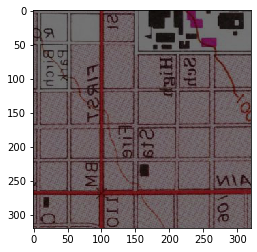

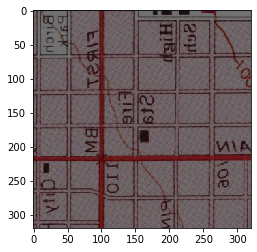

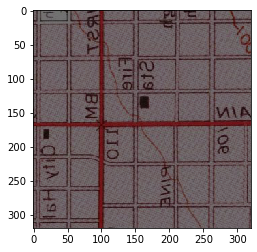

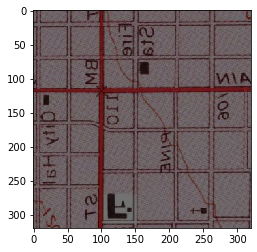

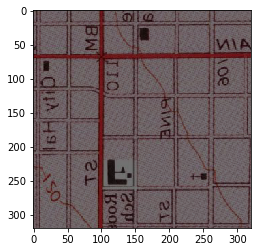

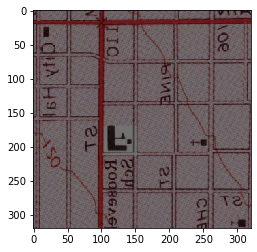

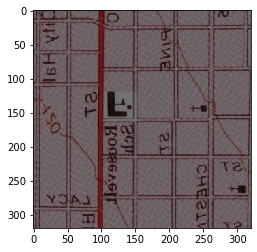

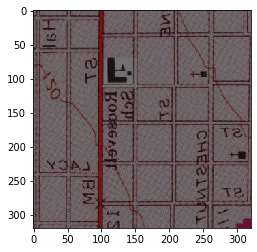

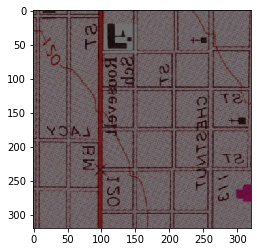

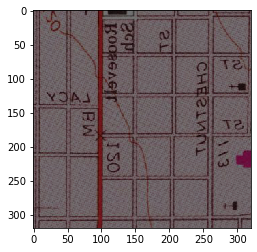

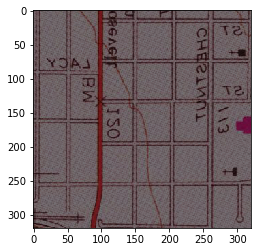

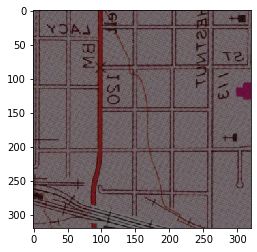

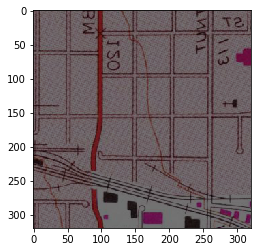

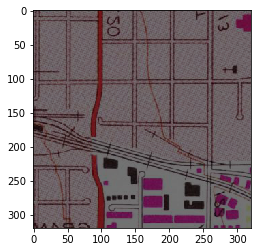

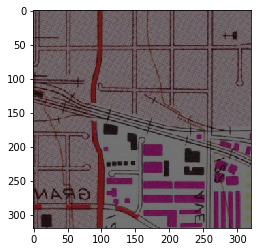

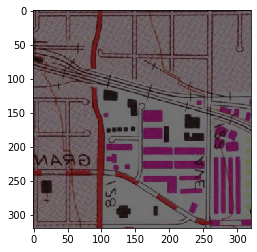

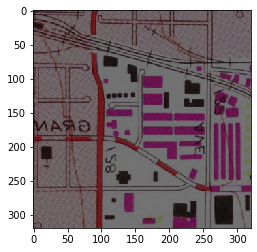

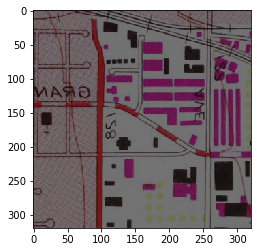

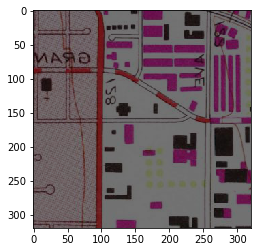

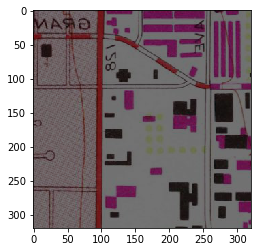

KeyboardInterrupt: 

In [32]:
predict(model, maps[0])